<a href="https://colab.research.google.com/github/ahmeda335/Deep_Learning_Projects/blob/main/Deep_Learning_Session3_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

<ipython-input-2-669f118e178f>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [4]:
from PIL import Image
import numpy as np

In [5]:
# Display the fifth image
img = Image.fromarray(x_train[0])

img = img.resize((100, 100))

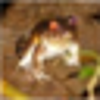

In [6]:
display(img)

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
y_train.shape

(50000, 1)

In [9]:
x_test.shape

(10000, 32, 32, 3)

In [10]:
y_test.shape

(10000, 1)

In [17]:
#scale image ---> 0 : 1
x_train = x_train.astype('float32') / 255
x_test= x_test.astype('float32') / 255

In [18]:
#one hot encoded label
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [19]:
def build_model(hp):
  base_model = VGG16(weights= 'imagenet', include_top=False, input_shape=(32, 32, 3))

  model = Sequential()

  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(units = hp.Int('units', min_value = 32, max_value = 256, step = 32), activation= 'relu'))
  model.add(Dense(10, activation = 'softmax'))

  #compile model
  model.compile(optimizer = Adam(learning_rate= hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
                loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [20]:
#intialize keras tuner
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials= 3,
    executions_per_trial = 1,
    directory = 'simple_training',
    project_name = 'cifar10_tuning'
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:
tuner.search(x_train, y_train, epochs = 3, validation_data = (x_test, y_test), shuffle = True, batch_size = 32)

Trial 3 Complete [00h 04m 12s]
val_accuracy: 0.8409000039100647

Best val_accuracy So Far: 0.8409000039100647
Total elapsed time: 00h 13m 32s


In [22]:
best_model = tuner.get_best_models(num_models = 1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 160)                 │          82,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,798,378 (56.45 MB)

 Trainable params: 14,798,378 (56.45 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
best_params = tuner.get_best_hyperparameters()

## Early Stopping.

In [27]:
model2 = Sequential([
    VGG16(weights= 'imagenet', include_top=False, input_shape=(32, 32, 3)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

model2.compile(optimizer = Adam(learning_rate= best_params[0]['learning_rate']), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
checkpoint = ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only = True)

In [30]:
model2.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks = [early_stop, checkpoint])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - accuracy: 0.6062 - loss: 1.1118 - val_accuracy: 0.8035 - val_loss: 0.5754
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - accuracy: 0.8365 - loss: 0.4883 - val_accuracy: 0.8214 - val_loss: 0.5497
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.8866 - loss: 0.3325 - val_accuracy: 0.8278 - val_loss: 0.5427
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 43ms/step - accuracy: 0.9215 - loss: 0.2347 - val_accuracy: 0.8395 - val_loss: 0.5146
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.9490 - loss: 0.1532 - val_accuracy: 0.8625 - val_loss: 0.4594
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9643 - loss: 0.1087 - val_accuracy: 0.8416 - val_loss: 0.5703
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.9715 - loss: 0.0844 - val_accuracy: 0.8575 - val_loss: 0.5495
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.9777 -